In [3]:
!pip install tfrecord

In [4]:
import re
from typing import Dict, List, Optional, Text, Tuple
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np

import torch
from torch.utils.data import Dataset, DataLoader
from tfrecord.torch.dataset import TFRecordDataset, MultiTFRecordDataset

"""Constants for the data reader."""

INPUT_FEATURES = ['elevation', 'th', 'vs',  'tmmn', 'tmmx', 'sph', 
                  'pr', 'pdsi', 'NDVI', 'population', 'erc', 'PrevFireMask']

OUTPUT_FEATURES = ['FireMask', ]

FEATURES = ['elevation', 'th', 'vs',  'tmmn', 'tmmx', 'sph', 
                  'pr', 'pdsi', 'NDVI', 'population', 'erc', 'PrevFireMask', 'FireMask']


# Data statistics 
# For each variable, the statistics are ordered in the form:
# (min_clip, max_clip, mean, standard deviation)
DATA_STATS = {
    # Elevation in m.
    # 0.1 percentile, 99.9 percentile
    'elevation': (0.0, 3141.0, 657.3003, 649.0147),
    # Pressure
    # 0.1 percentile, 99.9 percentile
    'pdsi': (-6.12974870967865, 7.876040384292651, -0.0052714925, 2.6823447),
    'NDVI': (-9821.0, 9996.0, 5157.625, 2466.6677),  # min, max
    # Precipitation in mm.
    # Negative values do not make sense, so min is set to 0.
    # 0., 99.9 percentile
    'pr': (0.0, 44.53038024902344, 1.7398051, 4.482833),
    # Specific humidity.
    # Negative values do not make sense, so min is set to 0.
    # The range of specific humidity is up to 100% so max is 1.
    'sph': (0., 1., 0.0071658953, 0.0042835088),
    # Wind direction in degrees clockwise from north.
    # Thus min set to 0 and max set to 360.
    'th': (0., 360.0, 190.32976, 72.59854),
    # Min/max temperature in Kelvin.
    # -20 degree C, 99.9 percentile
    'tmmn': (253.15, 298.94891357421875, 281.08768, 8.982386),
    # -20 degree C, 99.9 percentile
    'tmmx': (253.15, 315.09228515625, 295.17383, 9.815496),
    # Wind speed in m/s.
    # Negative values do not make sense, given there is a wind direction.
    # 0., 99.9 percentile
    'vs': (0.0, 10.024310074806237, 3.8500874, 1.4109988),
    # NFDRS fire danger index energy release component expressed in BTU's per
    # square foot.
    # Negative values do not make sense. Thus min set to zero.
    # 0., 99.9 percentile
    'erc': (0.0, 106.24891662597656, 37.326267, 20.846027),
    # Population density
    # min, 99.9 percentile
    'population': (0., 2534.06298828125, 25.531384, 154.72331),
    # We don't want to normalize the FireMasks.
    # 1 indicates fire, 0 no fire, -1 unlabeled data
    'PrevFireMask': (-1., 1., 0., 1.),
    'FireMask': (-1., 1., 0., 1.)
}

description = None
description = {}
for key in DATA_STATS.keys():
    description[key] = "float"

# single tfrecord
# tfrecord_path =  '/kaggle/input/next-day-wildfire-spread/next_day_wildfire_spread_train_00.tfrecord'
# index_path = None
# dataset =  TFRecordDataset(tfrecord_path, index_path, description)

# multi tfrec
file_pattern = '/kaggle/input/next-day-wildfire-spread/next_day_wildfire_spread{}.tfrecord'

# TRAIN
#sampling probability from different files
num_files = 15
splits = {} #keys inputed into file_pattern
for i in range(num_files):
    splits[f"_train_{i:02d}"] = 1.0/num_files
index_pattern = None
dataset = MultiTFRecordDataset(file_pattern, index_pattern, splits, shuffle_queue_size=1024)
BATCH_SIZE = 5
tfrec_loader = DataLoader(dataset, batch_size=BATCH_SIZE) # cannot shuffle here IterableDataset?

# EVAL
#sampling probability from different files
num_files = 2
splits = {} #keys inputed into file_pattern
for i in range(num_files):
    splits[f"_eval_{i:02d}"] = 1.0/num_files
index_pattern = None
dataset_val = MultiTFRecordDataset(file_pattern, index_pattern, splits, shuffle_queue_size=1024)


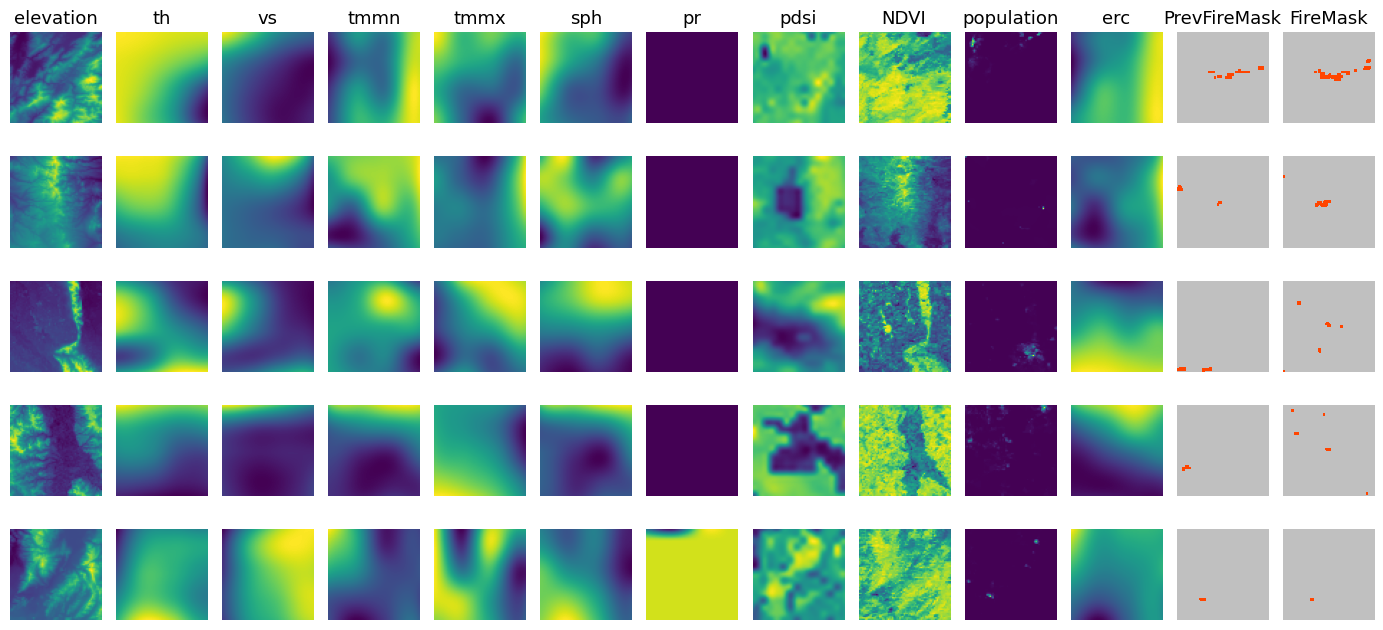

In [5]:
## VISUALIZE BATCH
def visualize_batch(data, feature_labels, dim = (64,64)):

    batchsize = len(data[feature_labels[0]])

    # Number of data variables
    n_features = len(feature_labels)
    # Variables for controllong the color map for the fire masks
    CMAP = colors.ListedColormap(['black', 'silver', 'orangered'])
    BOUNDS = [-1, -0.1, 0.001, 1]
    NORM = colors.BoundaryNorm(BOUNDS, CMAP.N)

    fig = plt.figure(figsize=(15,6.5))

    for i in range(batchsize):
        for j, key in enumerate(feature_labels):
            plt.subplot(batchsize, n_features + 1, i * (n_features + 1) + j + 1)
            if i == 0:  
                plt.title(key, fontsize=13)
            d = torch.reshape(data[key], (batchsize, dim[0], dim[1]))
            if key == "PrevFireMask" or key == "FireMask":
                plt.imshow(d[i,:,:], cmap=CMAP, norm=NORM)
            else:
                plt.imshow(d[i,:,:], cmap='viridis')
            plt.axis('off')
    plt.tight_layout()
    
data = next(iter(tfrec_loader))
visualize_batch(data, FEATURES)

In [21]:
# PREPROCESSING and data loading

import torchvision.transforms as transf

# create torch dataset --> filter tfrecords
TRAIN_DATASET_SIZE = 10 #9000 # totally in tf records 18,445 items
VAL_DATASET_SIZE = 5 #1000

class Dataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        if self.transform is not None:
            data_transf = self.transform(self.data[idx])
            return data_transf[:-1], data_transf[-1]
        return self.data[idx][:-1], self.data[idx][-1] #return (features, label)

def process_tfrec_dataset(tfrec_loader, dataset_size):
    reshaped_data = []
    filtered_data_uncertain = []
    selected_count = 0
    for data in iter(tfrec_loader):
        if -1 in data['FireMask'] or  -1 in data['PrevFireMask']:
            filtered_data_uncertain.append(data)
            continue

        #else data good:
        reshaped_d = torch.zeros(len(FEATURES),64,64)
        for i, k in enumerate(data):
            reshaped_d[FEATURES.index(k)] = torch.reshape(data[k][0], (64,64))
        reshaped_data.append(reshaped_d)

        selected_count += 1  
        if selected_count % 200 == 0: print(f"{selected_count} processed and selected")
        if selected_count >= dataset_size: 
            print(f"{selected_count} processed and selected")
            break
            
    return reshaped_data, filtered_data_uncertain

# runtime transforms
torch.Generator().manual_seed(123)
crop = transf.RandomCrop(size=(32,32))

tfrec_train_loader = DataLoader(dataset, batch_size=1)
tfrec_valid_loader = DataLoader(dataset_val, batch_size=1)

train_data, _ = process_tfrec_dataset(tfrec_train_loader, TRAIN_DATASET_SIZE)
train_data = Dataset(train_data, transform=crop)
valid_data, _ = process_tfrec_dataset(tfrec_valid_loader, VAL_DATASET_SIZE)
valid_data = Dataset(valid_data, transform=crop)

10 processed and selected
5 processed and selected


In [61]:
!pip install torchviz

  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4151 sha256=780e536b1a489b7a8f217021fc65647bbc15530bf3382e8339098a7535c37e9d
  Stored in directory: /root/.cache/pip/wheels/18/0c/ac/81bacd5a53085ac633beb52c80c08152db65a81e93b15b392d
Successfully built torchviz


In [69]:
# SIR CELLULAR AUTOMATON MODEL TORCH VERSION
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

def plot_cell_state(state, colormap=None, title=None, save_path=None, show=True):
    fig, ax = plt.subplots()

    p = ax.pcolormesh(state.cpu(), cmap=colormap, rasterized=True, vmin=0, vmax=1)
    fig.colorbar(p, ax=ax)
    if title is not None: plt.title(title)
    if save_path is not None:
        plt.savefig(save_path)
    if show: plt.show()
    
# iterace
def time_step(S, beta, gamma, mu, N, filter):
    # mu used as conv filter  dim:= (out, in, h, w)
    dim = (S.shape[0], S.shape[1]) # (32,32)
    
    S_past = S[:,:,0].clone()
    I_past = S[:,:,1].clone()
    R_past = S[:,:,2].clone()
#     S_new = torch.zeros(S.shape).to(device)
    
    # conv-sum
    NI = mu * N * S_past # mu-weighted symmetric cell connection
    NI = NI[None, :]
    sum = F.conv2d(NI, filter, stride=1, padding='same') 
    #TODO: solve 1/N_ij normalization here -> values can overflow otherwise
    
    #   S
    S[:,:,0] = S_past - beta * S_past * I_past - S_past * sum
    #   I
    S[:,:,1] = (1-gamma) * I_past + beta * S_past * I_past + S_past * sum
    #   R
    S[:,:,2] = R_past + gamma * I_past
    
#     S.register_hook(lambda grad: print(grad)) 
    print(S)
    return S

def cellular_sim(mu, fmask, T=4, beta=0.01, gamma=0.001):
    dim = (32,32)
    N = torch.ones(dim)
    N = N[None, :].to(device) #expand N params to obtain product NI with batch dim
#     N.requires_grad = True
#     N.retain_grad()
    # binary filter replacing the cellular 8-neighborhood ... V = [(-1,0),(-1,1),(0,1),(1,1),(1,0),(1,-1),(0,-1),(-1,-1)]    
    filter = torch.ones((1,1,3,3)) 
    filter[0,0,1,1] = 0
    filter = filter.to(device)
#     filter.requires_grad = True
#     filter.retain_grad()
    
    S = torch.ones((dim[0], dim[1], 3)).to(device) #state consisting of SIR values
    S[:,:,1] = fmask
    S[:,:,0] -= fmask
    S[:,:,2] *= 0
    #S cannot be leaf
#     S.requires_grad = True 
#     S.retain_grad()

    for t in range(T):
        S = time_step(S, beta, gamma, mu, N, filter)
    # plot_cell_state(S[:,:,1],  colormap='viridis', title=f"t={t}")
    return S

def comparative_cellular_loss(mu, fmask, fmask_t2, dist_fcn):
    S = cellular_sim(mu, fmask, T=1, beta=0.02, gamma=0.001) 
 
    loss = dist_fcn(fmask_t2, S[:,:,1])
    return loss

In [70]:
import torch.nn as nn
import torch.nn.functional as F
## NN specification
# - maybe upsampling, U-NET stuff etc. worth it here
class Model1(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(len(INPUT_FEATURES), 32, 3, padding='same')
        self.conv2 = nn.Conv2d(32, 64, 3, padding='same')
        self.conv3 = nn.Conv2d(64, 128, 3, padding='same')
        self.conv4 = nn.Conv2d(128, 256, 3, padding='same')
        self.convFin = nn.Conv2d(256, 1, 3, padding='same') #outputing (32x32) mu

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = torch.sigmoid(self.convFin(x)) #interval [0,1]
        return x
net = Model1()

epoch: 0
tensor([[[-0.1087,  1.1087,  0.0000],
         [ 0.4715,  0.5285,  0.0000],
         [ 0.4111,  0.5889,  0.0000],
         ...,
         [-2.0572,  3.0572,  0.0000],
         [-2.5931,  3.5931,  0.0000],
         [-1.1294,  2.1294,  0.0000]],

        [[-1.5792,  2.5792,  0.0000],
         [-2.2049,  3.2049,  0.0000],
         [-1.4249,  2.4249,  0.0000],
         ...,
         [-4.4485,  5.4485,  0.0000],
         [-5.4319,  6.4319,  0.0000],
         [-3.7063,  4.7063,  0.0000]],

        [[-1.5777,  2.5777,  0.0000],
         [-1.6910,  2.6910,  0.0000],
         [-0.7889,  1.7889,  0.0000],
         ...,
         [-5.6006,  6.6006,  0.0000],
         [-6.2159,  7.2159,  0.0000],
         [-3.2452,  4.2452,  0.0000]],

        ...,

        [[-2.1441,  3.1441,  0.0000],
         [-3.0715,  4.0715,  0.0000],
         [-0.1510,  1.1510,  0.0000],
         ...,
         [-6.9265,  7.9265,  0.0000],
         [-6.1468,  7.1468,  0.0000],
         [-3.6642,  4.6642,  0.0000]],

 

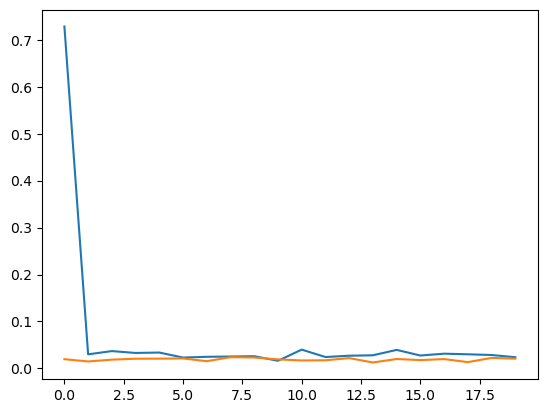

In [71]:
import time

torch.autograd.set_detect_anomaly(True)


def plot_grad_flow(named_parameters):
    '''Plots the gradients flowing through different layers in the net during training.
    Can be used for checking for possible gradient vanishing / exploding problems.
    
    Usage: Plug this function in Trainer class after loss.backwards() as 
    "plot_grad_flow(self.model.named_parameters())" to visualize the gradient flow'''
    ave_grads = []
    max_grads= []
    layers = []
    for n, p in named_parameters:
        if(p.requires_grad) and ("bias" not in n):
            layers.append(n)
            ave_grads.append(p.grad.abs().mean())
            max_grads.append(p.grad.abs().max())
    plt.bar(np.arange(len(max_grads)), max_grads, alpha=0.1, lw=1, color="c")
    plt.bar(np.arange(len(max_grads)), ave_grads, alpha=0.1, lw=1, color="b")
    plt.hlines(0, 0, len(ave_grads)+1, lw=2, color="k" )
    plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
    plt.xlim(left=0, right=len(ave_grads))
    plt.ylim(bottom = -0.001, top=0.02) # zoom in on the lower gradient regions
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
    plt.title("Gradient flow")
    plt.grid(True)
    plt.legend([Line2D([0], [0], color="c", lw=4),
                Line2D([0], [0], color="b", lw=4),
                Line2D([0], [0], color="k", lw=4)], ['max-gradient', 'mean-gradient', 'zero-gradient'])

def train(net, dataloaders, optimizer, num_epoch, validation=True):
    loss_hist = np.ones((num_epoch,2))*np.inf
    print_freq = 50
    
    mse = torch.nn.MSELoss() 
#     mae = torch.nn.MAELoss()
    
    net = net.to(device)
     
    for epoch in range(num_epoch):
        time_start = time.time()
        print(f"epoch: {epoch}")
        for loader_idx, phase in enumerate(dataloaders):
            if phase == 'train':
                net.train()
            else:
                if not validation:
                    break
                net.eval()

            loader = dataloaders[phase]
            running_loss = 0.0
            epoch_loss = 0.0
            # one batch
            for i, d in enumerate(loader, 0):
                inputs, labels = d
                features, fmask2 = inputs.to(device), labels.to(device)
                
                #zero the grad!
                optimizer.zero_grad()
                out = net(features)
                
#                 mu = out.swapaxes(0,2) #format expected by cellular loss
                
                loss = comparative_cellular_loss(out[0], features[-1], fmask2, mse)
                                
                if phase == 'train':
                    loss.backward()
                    
#                     plot_grad_flow(net.named_parameters())

                    optimizer.step()
         
                # statistics
                running_loss += loss.item()
                epoch_loss += loss.item()

                if i % print_freq == (print_freq-1): 
                    print(f'{phase}: [{epoch + 1}, {i + 1:5d}] loss: {running_loss / print_freq:.3f}')
                    running_loss = 0.0 
            # normalize metrics by the size of data
            epoch_loss /= dataloaders[phase].__len__()
            loss_hist[epoch,loader_idx] = epoch_loss
            epoch_time = time.time() - time_start
            print(f"{phase}-epoch {epoch} loss: {epoch_loss} time: {epoch_time:.2f}s")
            #torch.save(net, f'/kaggle/working/net_ep_{epoch}.pth')
    print("training finished")
    plt.plot(loss_hist)
    return loss_hist


data_loaders = {'train': train_data, 'valid': valid_data}
optimizer = torch.optim.SGD(net.parameters(), lr=0.02, momentum=0.6)
# optimizer = torch.optim.AdamW(net.parameters())
num_epoch = 20

loss_hist = train(net, data_loaders, optimizer, num_epoch)

In [60]:
# grad check

for name, param in net.named_parameters():

    print(name, param.grad.max())

conv1.weight tensor(0.)
conv1.bias tensor(0.)
conv2.weight tensor(0.)
conv2.bias tensor(0.)
conv3.weight tensor(0.)
conv3.bias tensor(0.)
conv4.weight tensor(0.)
conv4.bias tensor(0.)
convFin.weight tensor(0.)
convFin.bias tensor(0.)


torch.Size([32, 32])


NameError: name 'x' is not defined

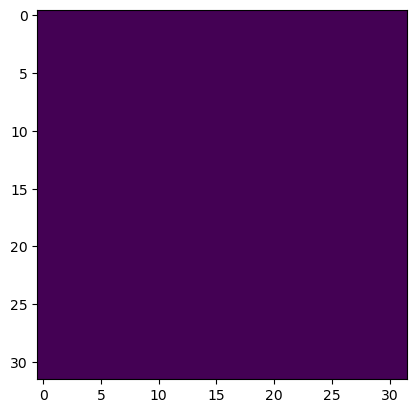

In [64]:
idx = 1
features, fmask2 = train_data.__getitem__(idx) 
fmask = features[-1]
print(fmask.shape)
plt.imshow(fmask)

from torchviz import make_dot, make_dot_from_trace
make_dot(net(x), params=dict(model.named_parameters()))

In [ ]:
plt.imshow(fmask2)

In [ ]:
mu = net(features.to(device))

S = cellular_sim(mu, fmask, T=4, beta=0.01, gamma=0.001)
plt.imshow(S[:,:,1].cpu().detach())
print(mu)

In [ ]:
S = cellular_sim(mu, fmask, T=4, beta=0.02, gamma=0.001) 
                     #V = [(-1,0),(-1,1),(0,1),(1,1),(1,0),(1,-1),(0,-1),(-1,-1)])    
dist_fcn = torch.nn.MSELoss() 
    
loss = torch.nn.MSELoss(fmask2.to(device), S[:,:,1])
loss.requires_grad_()